# Important Information on Interactivity

After installing the prerequisite packages, to enable the dynamical content in this Jupyter notebook, please configure your Jupyter client *in termonal* using 

```
jupyter nbextension enable --py --sys-prefix ipyleaflet
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

# Init

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

from ipywidgets import HTML

plt.style.use('default')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

Palette = 'magma'
CycPalette = 'Greys'
DivPalette = 'RdYlGn'

FigSize = (20,12)
FigSizeMono = (20,6)
DPI = 72

# An Interactive Map

In [3]:
pi = np.pi

UserL = 2
MBoxL = 3

def SphericalDistance(PtA,PtB):
    
    PtALat = PtA[0] * pi / 180
    PtALon = PtA[1] * pi / 180
    
    PtBLat = PtB[0] * pi / 180
    PtBLon = PtB[1] * pi / 180
                
    rTerra = 6371009 # metres
                 
    return 2*rTerra*np.arcsin(np.sqrt(np.sin((PtALat-PtBLat)/2)**2+np.cos(PtALat)*np.cos(PtBLat)*np.sin((PtALon-PtBLon)/2)**2))
                 
                       

KeyLocation = (-42.40469961745638, 173.68168174089007)
center=(-42.404446107412646, 173.67427500707868)


from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, CircleMarker, Popup, GeoJSON

m = Map(
    center=center,
    zoom=12,
    title = 'Group 11'
    )

m.layout.width = '1024px'
m.layout.height = '768px'

m.layout.arrange= 'center'

marker = Marker(location=center, draggable=False)
m.add_layer(marker)


m.add_layer(S)

def handle_click(**kwargs):
    print(f"Hospital Location (Lat / Lon): {kwargs['coordinates']}")
    
marker.on_click(handle_click)
# User Clickable Interaction

Ci = 0
Clicked = False
def handle_map_interaction(**kwargs):
   # markerU = CircleMarker(location=(0,0), draggable=True, visible = False)
   # m.add_layer(markerU)
    #m.add_layer(markerU)
    global Clicked, Ci, marker
    #print(kwargs)
    Ci += 1
    if kwargs['type'] == 'click' and Clicked == False:
        Clicked = True
        
        NLoc =  kwargs['coordinates']
        
        markerU = CircleMarker(location=NLoc, draggable=True, color = '#454545')
        try:
            m.substitute_layer(m.layers[UserL],markerU)
            m.remove_layer(m.layers[MBoxL])
        except IndexError:
            m.add_layer(markerU)
            
        message = HTML()
        
        D = SphericalDistance(KeyLocation,NLoc)
        
        message.value = f'Risk index is .<br>Distance to Nearest Hospital: {D:.5g}m<br>This is about {D/1.2/60:.0f} minutes on foot.'
        
        popup = Popup(
        location=NLoc,
        close_button=False,
        auto_close=False,
        child = message,
        close_on_escape_key=True
        )
        m.add_layer(popup)

        # Popup associated to a layer
        markerU.popup = message

        

    if Ci%2 == 0:
        Clicked = False
        
m.on_interaction(handle_map_interaction)

# Popup with a given location on the map:


m

NameError: name 'S' is not defined

# QGIS Street Map Graphication

In [103]:
def FindNearest(Points,Location):
    
    IPoints = np.array(Points) # Force to be n x 2 array
   
    Dist = (IPoints[:,0]-Location[0])**2 + (IPoints[:,1]-Location[1])**2
    
    Loc = np.where(Dist == np.min(Dist))[0] # In case there's a tie, pick the first one!

    return IPoints[Loc,:][0]

import shapefile

st = shapefile.Reader("./Streets")

tL = st.shapes()

len(st)
len(tL)

5252

[1820780.0286870003, 5772816.050310823, 1945945.7997040004, 5851644.005863661]


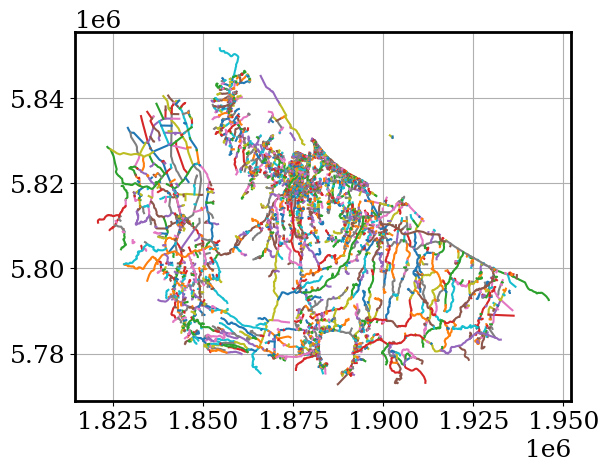

In [120]:
PointSet = []
figlim = st.bbox

print(figlim)

fig = plt.figure()
ax = fig.add_subplot(111)

#plt.xlim(figlim[0],figlim[1])
#plt.ylim(figlim[2],figlim[3])

#ax.set_aspect = 'equal'

ax.grid()

for i in range(len(st)):

    PointSet += tL[i].points
    
    PAR = np.array(tL[i].points)

    PAR = PAR.reshape([-1,2])

    ax.plot(PAR[:,0],PAR[:,1])

In [121]:
seen = set()
uniq = []

Intersections = PointSet.copy()

for x in PointSet:
    if x not in seen:
        uniq.append(x)
        seen.add(x)
        
for x in uniq:  
    Intersections.remove(x)

fig = plt.figure()
#ax = fig.add_subplot(111)

#plt.xlim(figlim[0],figlim[1])
#plt.ylim(figlim[2],figlim[3])

ax.set_aspect = 'equal'

ax.grid()


seenPoints = np.array(Intersections)


<Figure size 640x480 with 0 Axes>

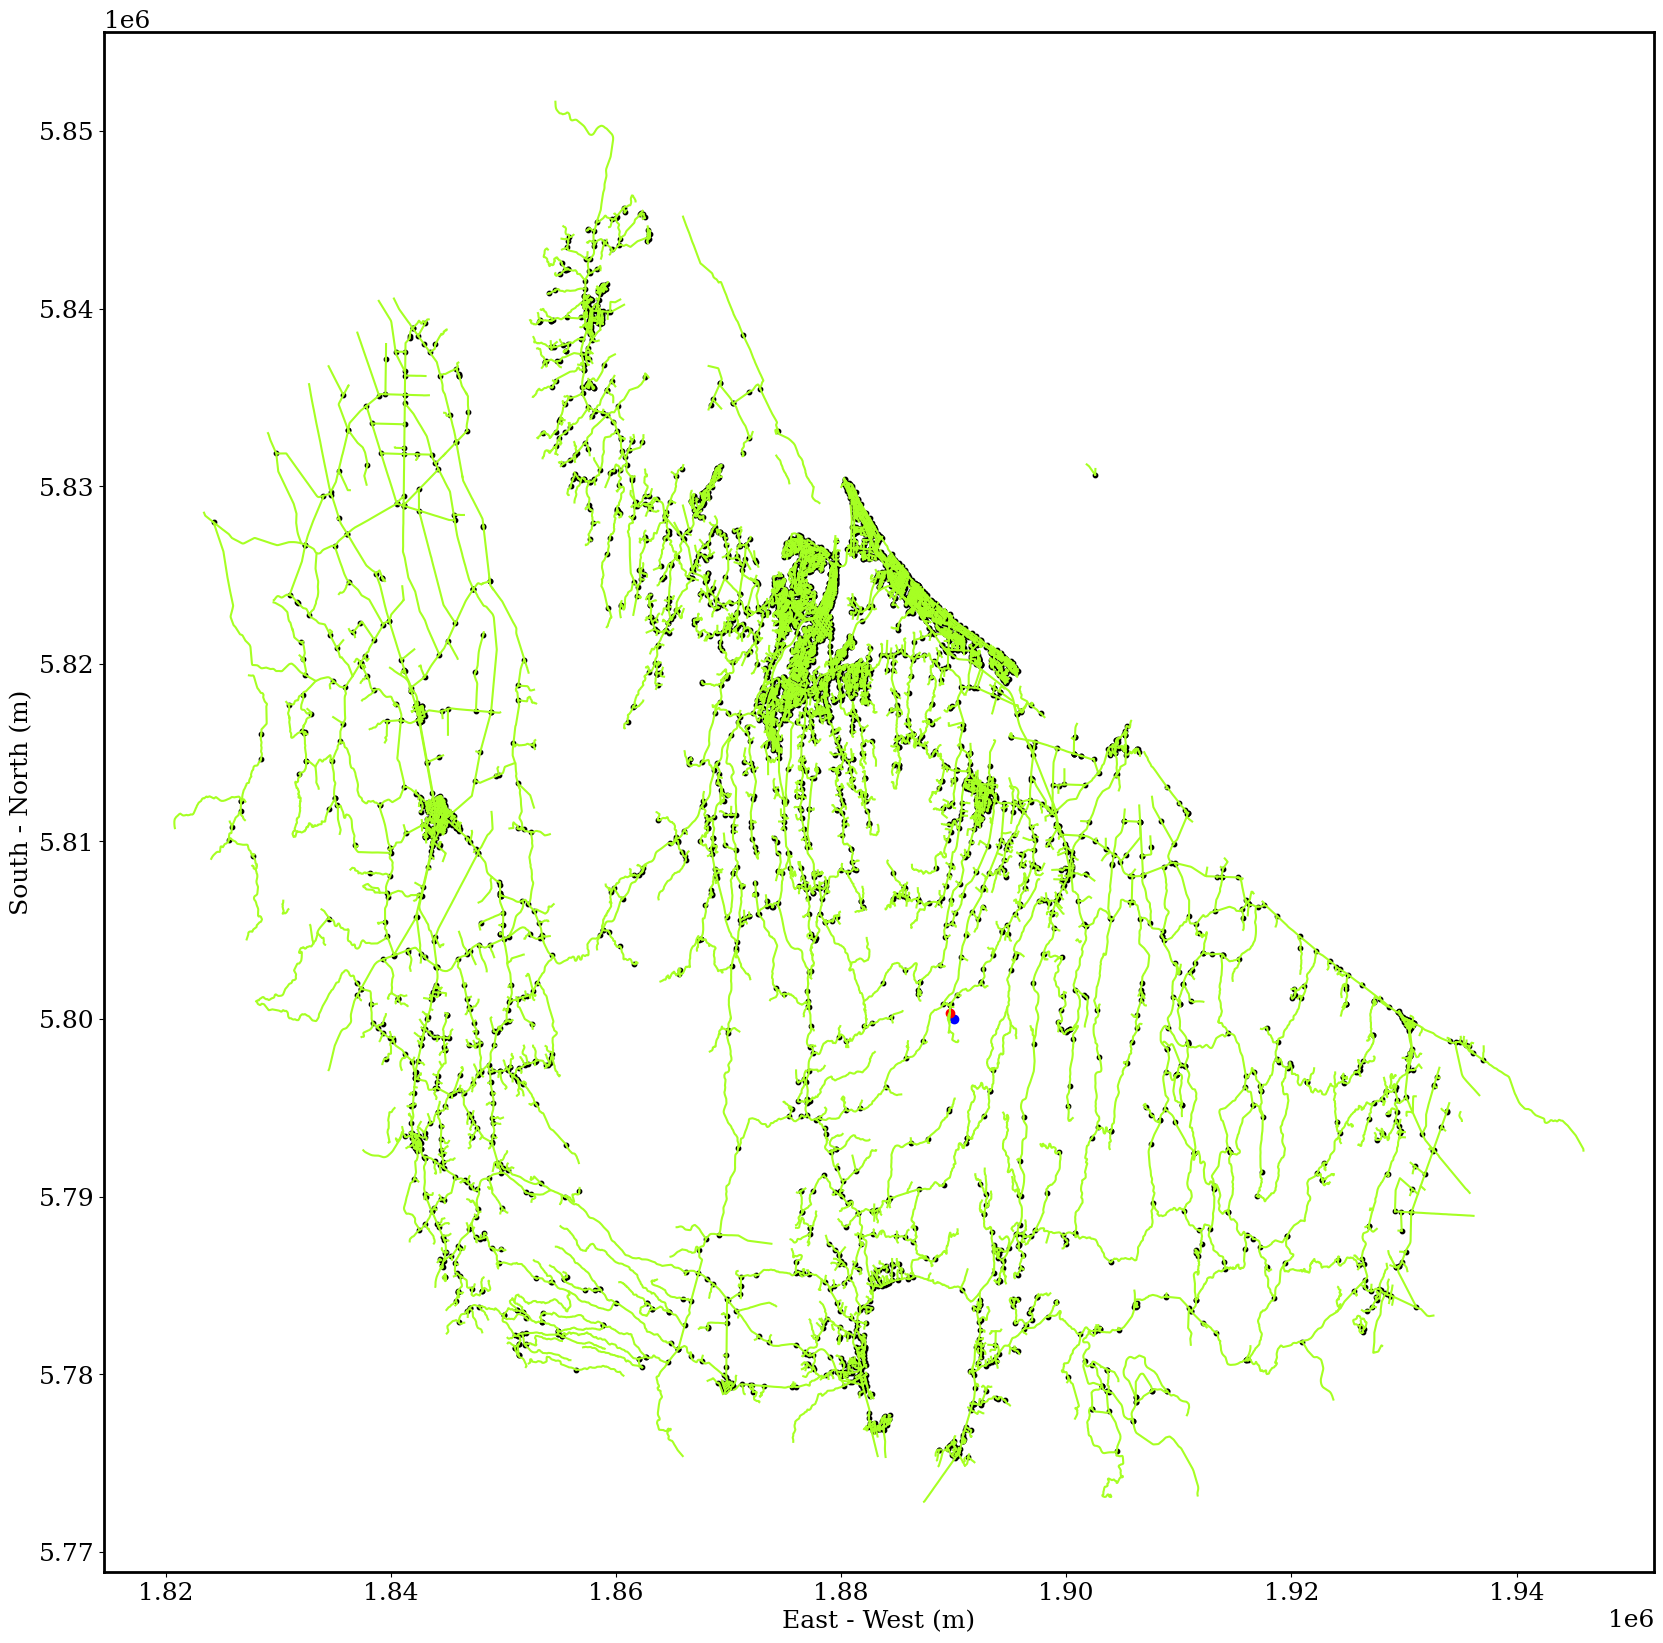

In [174]:
InputX, InputY = 1.89e6,  5.8e6

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)


plt.scatter(seenPoints[:,0],seenPoints[:,1],color = 'k', s = 10)

for i in range(len(st)):
    
    PAR = np.array(tL[i].points)

    PAR = PAR.reshape([-1,2])

    ax.plot(PAR[:,0],PAR[:,1], color = '#a6ff23')

ax.set_xlabel('East - West (m)')

ax.set_ylabel('South - North (m)')

plt.scatter([InputX],[InputY],color = 'b')

Output = FindNearest(Intersections,[InputX,InputY])


plt.scatter([Output[0]],[Output[1]],color = 'r')

In [167]:
StreetList = []
for i in range(len(st)):
    StreetList.append(tL[i].points)

In [171]:
a = FindNearest(Intersections,[5.8e6,1.89e6])

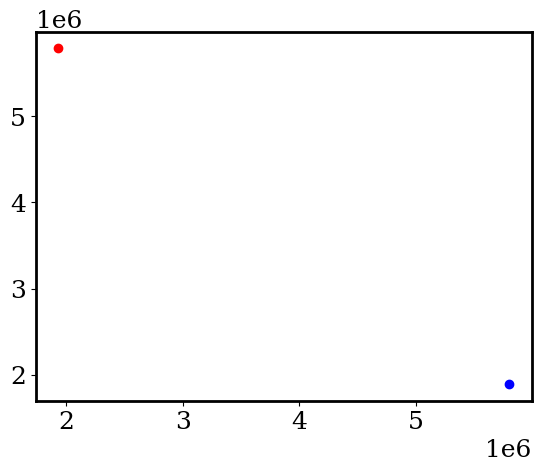

# Overlay!

In [176]:
River100 = shapefile.Reader("./100m_River")

River100.__geo_interface__['type']


'FeatureCollection'

In [189]:
s = River100.shape(0)
geoj = s.__geo_interface__
geoj["type"]

'Polygon'

TraitError: The 'data' trait of a GeoJSON instance expected a dict, not the Shape at '0x7f82d1f4d880'.

In [186]:
r = shapefile.Reader("./100m_River")

w = shapefile.Writer("./100m_River_Copy")
w.fields = r.fields[1:] # skip first deletion field

# or GeoJSON dicts
for shaperec in r.iterShapeRecords():
    w.record(*shaperec.record)
    w.shape(shaperec.shape.__geo_interface__)

w.close()	

In [5]:
import json
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, CircleMarker, Popup, GeoJSON

m = Map(
    center=center,
    zoom=12,
    title = 'Group 11'
    )

m.layout.width = '1024px'
m.layout.height = '768px'

m.layout.arrange= 'center'

with open('100m_River.json', 'r') as f:
    data = json.load(f)

S = GeoJSON(data = data, style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    })

m.add_layer(S)

m

Map(center=[-42.404446107412646, 173.67427500707868], controls=(ZoomControl(options=['position', 'zoom_in_text…